In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyswarm import pso
from scipy.optimize import minimize


In [466]:
chips_data = pd.read_csv("chips.csv", header=None)[1:]
chips_X = chips_data.loc[:, 0:1]
chips_y = np.where(chips_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [467]:
geyser_data = pd.read_csv("geyser.csv", header=None)[1:]
geyser_X = geyser_data.loc[:, 0:1]
geyser_y = np.where(geyser_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [468]:
class SVM:
    X_train = None
    y_train = None
    X_test = None
    y_test = None

    def fit(self, X, y, kernel_name='linear', C=10):
        self.X_train = np.array(X, dtype=np.float)
        self.y_train = np.array(y)
        self.N_train = self.X_train.shape[0]
        self.k_train = self.X_train.shape[1]
        self.C = C
        self.w = np.random.sample(self.k_train)
        self.w0 = np.random.random()
        self.__train__()


    def predict(self, X):
        return np.sign(self.K(X))

    def M(self, X):
        return self.w @ X.T - self.w0

    def __possitive_cut__(self, x):
        return (x + np.abs(x))/2

    def K(self, X=None, w=None, w0=None):
        X = X if X is not None else self.X_train
        w = w if w is not None else self.w
        w0 = w0 if w0 is not None else self.w0
        return w @ X.T - w0
        # return np.exp(-(w - X)**2).sum(axis=1) - w0


    def __opt_func__(self, lamd):
        a = lamd.reshape((-1,1))
        b = self.y_train.reshape((-1,1))
        # M = self.y_train * (lamd[0:2] @ self.X_train.T - lamd[2])
        M = self.y_train * self.K(w=lamd[0:2], w0=lamd[2])
        return self.__possitive_cut__(1 - M).sum() + .5/self.C * np.linalg.norm(lamd[0:2], 2)
        # return .5 * (a*a.T * b*b.T * (self.X_train @ self.X_train.T)).sum() - a.sum()

    def __constraints__(self, lamd):
        return lamd - (lamd*self.y_train).sum()

    def __train__(self):
        ub = np.full(self.N_train, self.C)
        lb = np.full(self.N_train, 0)
        lamd_init = np.random.sample(self.N_train) * self.C
        bounds = np.full((self.N_train, 2), (0, self.C))
        constraints = (
            {
                'type': 'eq', 'fun': self.__constraints__
            }
        )
        # lamd, fopt = pso(self.__opt_func__, lb=lb, ub=ub, f_ieqcons=self.__constraints__, swarmsize=100, maxiter=100)
        print(np.hstack((self.w, self.w0)))
        res = minimize(self.__opt_func__, np.hstack((self.w, self.w0)))
        print(res)
        self.w = res.x[0:2]
        self.w0 = res.x[2]
        print(self.w)
        print(self.w0)
        # lamd = res.x
        # self.w = np.array([(lamd * self.y_train * self.X_train[:, 0]).sum(axis=0), (lamd * self.y_train * self.X_train[:, 1]).sum(axis=0)])
        # print((lamd*self.y_train).sum())
        # print(self.w.shape, self.w)
        # print(self.w @ self.X_train.T)
        # print(self.w0)
        # print(self.w @ self.X_train.T - self.w0)
        # print(self.M(self.X_train))
        # iter = np.squeeze(np.where(np.all([( self.M(self.X_train) * self.y_train) == 1, lamd>0], axis=0)))[0]
        # self.w0 = self.w @ self.X_train[iter].T - self.y_train[iter]

    def visualize(self, X=None, y=None):
        X = X or self.X_test or self.X_train
        y = y or self.y_test or self.y_train
        xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
        pred = self.predict(np.c_[xx.ravel(), yy.ravel()])
        pred = pred.reshape(xx.shape)
        pred[pred == -1] = 0.
        pred = pred.astype(np.int8)

        plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))

        plt.scatter(X[:,0], X[:,1], c=y)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.show()


[0.40810433 0.96272262 0.71965335]
      fun: 55.13541949211335
 hess_inv: array([[ 5.52923517e-04, -8.93440823e-03, -2.61486885e-02],
       [-8.93440823e-03,  1.82055145e-01,  5.44784002e-01],
       [-2.61486885e-02,  5.44784002e-01,  1.63806244e+00]])
      jac: array([ 7.00122786,  3.05001545, -0.76840878])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 320
      nit: 15
     njev: 77
   status: 2
  success: False
        x: array([ 0.03525385, -1.43483369, -4.26486366])
[ 0.03525385 -1.43483369]
-4.26486365690788


<ipython-input-468-887e62eaa699>:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))


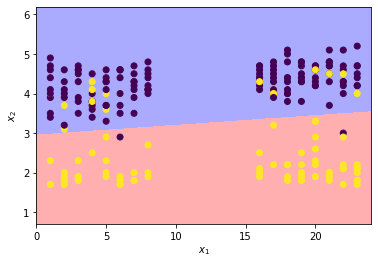

In [469]:
svm = SVM()
svm.fit(geyser_X, geyser_y)
svm.visualize()
# print(svm.predict(np.array(geyser_X, dtype=np.float)))
# print(geyser_y)